# **Titanic Survivability Prediction Using Linear Regression**

## **Introduction**

In [1]:
import os
from pathlib import Path
import torch, numpy as np, pandas as pd

In [2]:
path=Path('titanic')

In [3]:
df=pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Printing the sum of NA values for all columns
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# Replacing NA values with the mode (most common value)
modes = df.mode().iloc[0]           # getting the 1st mode as if there are multiple modes, it returns all of them
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.fillna(modes, inplace=True)          # Replacing the values in place

In [7]:
df.isna().sum()                 # No more NA values!

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
df.describe(include=(np.number))        # Getting a general idea of our data (inc. only columns with numeric data)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot: >

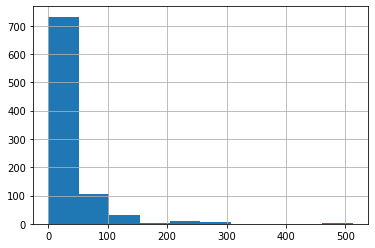

In [9]:
df['Fare'].hist()           # Most fares between $0-50, with a few fares between $450-500

For our dataset, `Fare` is a long tailed distribution.

Some models, including regression models and neural networks do not 'like' long tailed distributions. They usually perform badly when long tailed distribution exists.

One sure-shot way to fix a long tailed distribution is to find the log as log makes big values 'less big' while not affecting the smaller values much.
We normally take log of values which grow exponentially, e.g. population, money, etc.

We take the log of the value of Fare + 1 as:
1. log(0) is undefined, so, there may be issues if the value of Fare is 0
2. Taking Fare + 1 instead of Fare helps us avoid take the log of very small numbers (which usually results in large negative numbers)

In [10]:
df['LogFare'] = np.log(df['Fare']+1)

<AxesSubplot: >

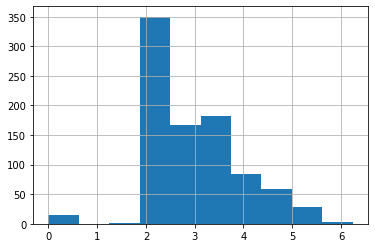

In [11]:
df['LogFare'].hist()        # Now the distribution is much more 'centered'

#### **Converting non-numeric columns to numeric/boolean columns**

e.g. The column `Sex` has 2 values: male and female, so dividing the column `Sex` into 2 boolean columns:
1. `Sex_male`
2. `Sex_female`

If the passenger is male, `Sex_male` will be 1 and `Sex_female` will be 0.

We divide it into 2 columns instead of substituting the number 0 in place of male and 1 in place of female for interpretability purposes. If numeric values were provided in the same column, the model may provide a coeffecient for the `Sex` column as 0.2, but, 0.2  doesn't imply male or female.

In [12]:
# Taking a look into the non-numeric columns
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [13]:
df=pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])        # Converting string columns to boolean columns
df.columns              # You can view the added columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [14]:
added_cols=['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [15]:
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1


In [16]:
from torch import tensor

# Converting our dependent variable - Survived into a tensor
t_dep = tensor(df.Survived)

In [17]:
# Choosing our independent variables and converting them to tensors
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep  = tensor(df[indep_cols].values, dtype=torch.float)         # data type should be float if we are going to multiply things together

In [18]:
t_indep.shape               # Gives the size and dimensionality of the vector, VVV important attribute

torch.Size([891, 12])

In [19]:
len(t_indep.shape)          # Gives the rank of a tensor

2

## **Setting up a Linear Model**

In [20]:
torch.manual_seed(42)           # Can be any random number, when seed is same, we get the same 'random' numbers

# Number of coefficients = number of columns
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5            # To initialize random numbers between -0.5 and 0.5 for each coefficient

In [21]:
t_indep.shape

torch.Size([891, 12])

In [22]:
coeffs.shape

torch.Size([12])

In [23]:
t_indep * coeffs    # We perform broadcasting - multiplying each coefficient by each value of each independent variable

# These are not normalized, values for most columns between -1 and 1 but the 1st column has larger values

tensor([[ 8.4099,  0.4150, -0.0000,  ..., -0.0000,  0.0000,  0.0936],
        [14.5262,  0.4150, -0.0000,  ..., -0.3668,  0.0000,  0.0000],
        [ 9.9390,  0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0936],
        ...,
        [ 9.1745,  0.4150, -0.2343,  ..., -0.0000,  0.0000,  0.0936],
        [ 9.9390,  0.0000, -0.0000,  ..., -0.3668,  0.0000,  0.0000],
        [12.2326,  0.0000, -0.0000,  ..., -0.0000,  0.4346,  0.0000]])

In [24]:
vals, indices = t_indep.max(dim=0)          # dim=0 indicates we want maximum by rows (max for each column)
# vals stores the maximum values for each column and indices stores the index posn of the maximum values

# Normalizing
t_indep = t_indep/vals          # Again we perform broadcasting, but this time we divide each value in t_indep by each value in vals

In [25]:
t_indep * coeffs        # Now the values are normalized

tensor([[ 0.1051,  0.0519, -0.0000,  ..., -0.0000,  0.0000,  0.0936],
        [ 0.1816,  0.0519, -0.0000,  ..., -0.3668,  0.0000,  0.0000],
        [ 0.1242,  0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0936],
        ...,
        [ 0.1147,  0.0519, -0.0390,  ..., -0.0000,  0.0000,  0.0936],
        [ 0.1242,  0.0000, -0.0000,  ..., -0.3668,  0.0000,  0.0000],
        [ 0.1529,  0.0000, -0.0000,  ..., -0.0000,  0.4346,  0.0000]])

In [26]:
preds = (t_indep*coeffs).sum(axis=1)            # Summing up the coefficient values gives us the predicted target value, will be very inaccurate as coefficients are random numbers right now

# axis=1 ensures that we find out the sum of values in columns, getting a prediction for each row

In [27]:
preds[:10]

tensor([0.7371, 0.0391, 0.9206, 0.4639, 0.7542, 1.0459, 0.2906, 0.7982, 0.9089,
        0.3994])

In [28]:
# Finding out how wrong our predictions are
loss = torch.abs(preds - t_dep).mean()
loss

# Ideally loss should be 0, it is a value between 0 and 1

tensor(0.6056)

In [29]:
# Making the functions for calculating predictions and loss

def calc_preds(coeffs, indeps):
    return (indeps*coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

## **Doing a gradient descent step**

In [30]:
coeffs.requires_grad_()         # Tracks the operation of the tensor, used in Backpropagation 

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,
         0.4408, -0.3668,  0.4346,  0.0936], requires_grad=True)

In [31]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6056, grad_fn=<MeanBackward0>)

In [32]:
loss.backward()         # Performing Backpropagation 

In [33]:
coeffs.grad             # E.g. tells us that if we reduce the coefficient corresponding to age, we will be closer to the actual/expected result

tensor([ 0.0883,  0.0272,  0.0056,  0.0608,  0.3423, -0.0853, -0.1324,  0.0202,
         0.3692, -0.0786,  0.0842,  0.2514])

In [34]:
# As most values are positive in the coeffs tensor, we perform subtraction as our aim is to push the loss value closer to 0
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)          # new_coeffs=old_coeffs−learning_rate×∇loss
    # .sub_ performs subtraction in place

In [35]:
print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5696, grad_fn=<MeanBackward0>)


## **Training the Linear Model**

In [36]:
# Splitting the dataset into training and testing set
from fastai.data.transforms import RandomSplitter

trn_split, val_split = RandomSplitter(seed=42)(df)

In [37]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

len(trn_indep), len(val_indep)

(713, 178)

In [38]:
# Function to update the coefficients
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)

In [39]:
# This function has all the steps we need to perform in every epoch

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [40]:
# Function to initialize the coefficients
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [41]:
# Function to train the model
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(42)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr=lr)
    return coeffs

In [42]:
coeffs = train_model(epochs=20, lr=0.015)

# As we can see the loss decreases from 0.603 from the 1st epoch to 0.376 after the 20th epoch

0.603; 0.598; 0.587; 0.571; 0.551; 0.526; 0.497; 0.466; 0.435; 0.405; 0.397; 0.418; 0.439; 0.451; 0.451; 0.438; 0.414; 0.385; 0.371; 0.376; 

In [43]:
# Function to return coefficients and their values
def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))

show_coeffs()

{'Age': tensor(0.3836),
 'SibSp': tensor(0.3705),
 'Parch': tensor(-0.1031),
 'LogFare': tensor(0.6025),
 'Sex_male': tensor(-0.4575),
 'Sex_female': tensor(0.4583),
 'Pclass_1': tensor(0.2893),
 'Pclass_2': tensor(0.3114),
 'Pclass_3': tensor(-0.1002),
 'Embarked_C': tensor(-0.0082),
 'Embarked_Q': tensor(0.2484),
 'Embarked_S': tensor(-0.0693)}

Analyzing some of the results above....

`Pclass_1` and `Pclass_2` value being >0 indicate that passengers belonging to 1st or 2nd class had **higher than average** chances of survival
`Pclass3` value being <0 indicates that passengers belonging to 3rd class had **lower than average** chances of survival

NOTE that this 'analysis' **may not be completely accurate**, especially considering the loss is still pretty high at 0.376. E.g. the results indicate that older people had a significantly higher chance of survival, but that is false.

So, it is a good practice to glance through this data, but one should avoid forming conclusions based on this data, yet.

## **Measuring Accuracy**

In [44]:
# Calculating the predictions
preds = calc_preds(coeffs, val_indep)

In [45]:
results = val_dep.bool() == (preds>0.5)     # pred is a value between 0 and 1, pred>0.5 indicates the prediction edging towards the passenger surviving
results[:20]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False,  True,  True, False,  True,  True,  True,  True])

In the 1st 20 predictions, we are correct 4/20 times. This gives us a 80% accuracy.

This is just a calculation based on the first 20 samples and may not reflect the accuracy for the complete dataset. (E.g. if we took only the 1st 10 values, ee would have 100% accuracy, which is not true.)

In [46]:
results.float().mean()          # We are right 78% of the time
# Result stores 1 (True) for a correct prediction and 0 (False) for a wrong prediction, so, we can use results.float().mean() to find the accuracy

tensor(0.7865)

In [47]:
# Making a function to calculate accuracy
def acc(coeffs):
    return (val_dep.bool() == (calc_preds(coeffs, val_indep)>0.5)).float().mean()

## **Using Sigmoids**

In [48]:
preds[:20]

tensor([ 1.3833,  0.0151, -0.2473,  0.2871,  0.1593,  0.2924,  0.6095,  1.0895,
        -0.0514,  0.7983, -0.2621, -0.1525, -0.3376,  0.9324, -0.2694,  0.2985,
         0.3944,  1.1213,  0.2898,  0.6568])

As you can see, sometimes we are getting values < 0 or > 1, which shouldn't happen as 0 indicates didn't survive and 1 indicates survive.

We need to squash all the values between 0 and 1

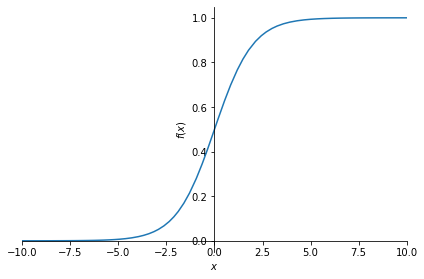

In [49]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-10, 10))         # Plotting the function for the values between -10 and 10

Some observations about the function from it's graph:
1. It is pretty close to a straight line between 0 and 1 (our desired range)
2. It is very close to 0 for values < -5
3. It is very close to 1 for values > 5

Therefore, this is an ideal function for our usecase. It is called the **sigmoid function**.

PyTorch already has an inbuilt sigmoid() function!

In [50]:
# Redefining calc_preds and using the sigmoid function
def calc_preds(coeffs, indeps):
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

Re-training the model using a different learning rate

In [51]:
coeffs = train_model(epochs= 20, lr=2)

0.546; 0.510; 0.432; 0.344; 0.297; 0.276; 0.260; 0.245; 0.230; 0.218; 0.210; 0.205; 0.202; 0.201; 0.200; 0.199; 0.199; 0.199; 0.199; 0.199; 

The learning rate decreased to 0.199, this is a huge improvement on using a learning rate of 0.015!

In [52]:
acc(coeffs)             # Our accuracy increased to 82.58%!

tensor(0.8258)

In [53]:
show_coeffs()

{'Age': tensor(-0.9615),
 'SibSp': tensor(-0.1795),
 'Parch': tensor(-0.0275),
 'LogFare': tensor(1.4206),
 'Sex_male': tensor(-13.5629),
 'Sex_female': tensor(11.0366),
 'Pclass_1': tensor(4.3148),
 'Pclass_2': tensor(1.9842),
 'Pclass_3': tensor(-8.3257),
 'Embarked_C': tensor(1.4056),
 'Embarked_Q': tensor(0.4748),
 'Embarked_S': tensor(-4.2367)}

## **Submitting to Kaggle** (Optional)

Kaggle provides a seperate test.csv file which has seperate test data

In [54]:
test_df = pd.read_csv(path/'test.csv')

Performing all the transformations we made on training set on the test set

One of the rows in the testing set has an empty Fare column (NA), even though none of the Fare values were NA in the testing dataset, so we fill the single NA column in the test set with 0

In [55]:
test_df['Fare'] = test_df.Fare.fillna(0)           

In [56]:
test_df.fillna(modes, inplace=True)
test_df['LogFare'] = np.log(test_df['Fare']+1)
test_df = pd.get_dummies(test_df, columns=["Sex", "Pclass", "Embarked"])

test_indep = tensor(test_df[indep_cols].values, dtype=torch.float)
tst_indep = test_indep/vals

In [57]:
test_df["Survived"] = (calc_preds(test_indep, coeffs)>0.5).int()        # .int() rounds off the values so we either have a 0 for didn't survive or 1 for survived

Creating a dataframe with only 2 columns: PassengerId and Survived, for submission to Kaggle

In [58]:
sub_df = test_df[['PassengerId', 'Survived']]

In [59]:
sub_df.to_csv('sub.csv', index=False)           # to_csv method creates an index by default, we don't want an index so we set index to False

The file is saved as `sub.csv`, you can access it from the base path folder and submit it to Kaggle!

## **Matrix Multiplication**

'*' - element wise multiplication
'@' - matrix multiplication

In [60]:
(val_indep * coeffs).sum(axis=1)

tensor([ 13.7970, -21.2089, -20.2916, -15.0504, -15.5151, -15.5428,   4.6713,
          9.0484, -25.3779,   4.5183, -26.0116, -20.1638, -25.6322,   3.3943,
        -26.0754, -13.2708, -13.5112,   9.2293, -15.5339,  -1.3815, -25.9162,
        -13.4030,  17.3351,   9.1294, -25.8909, -20.9906,  -0.9966, -13.4751,
        -25.8133,   3.3910,   9.1594,  -0.9587, -25.8561, -25.9904,  13.7249,
         -0.8578, -13.2402,  17.4366, -25.9123,  -1.3504, -15.4878, -25.9123,
        -15.5130,  17.3621, -25.8642,  -1.1979, -25.5155, -25.6922, -21.2304,
         -1.3098,  -8.3202, -25.4740, -25.5407, -25.9510, -15.5719, -15.6440,
        -21.2085, -25.9416, -25.8763, -25.8215,  -7.4385, -25.8771, -13.6646,
        -25.8794,   8.9831, -12.7492, -15.5031, -25.8599, -21.2835,   8.8520,
        -25.9403,   4.4535, -15.6320, -25.8785, -13.0236, -25.8232, -25.9123,
        -12.9371, -15.4430, -15.7491, -15.0371,  17.7193, -25.9042, -25.9334,
          8.7392,  -9.6512,  -7.0115,  12.0065,  14.8002, -15.49

In [61]:
val_indep @ coeffs

tensor([ 13.7970, -21.2089, -20.2916, -15.0504, -15.5151, -15.5428,   4.6713,
          9.0484, -25.3779,   4.5183, -26.0116, -20.1638, -25.6322,   3.3943,
        -26.0754, -13.2708, -13.5112,   9.2293, -15.5339,  -1.3815, -25.9162,
        -13.4030,  17.3351,   9.1294, -25.8909, -20.9906,  -0.9966, -13.4751,
        -25.8133,   3.3910,   9.1594,  -0.9587, -25.8561, -25.9904,  13.7249,
         -0.8578, -13.2402,  17.4366, -25.9123,  -1.3504, -15.4878, -25.9123,
        -15.5130,  17.3621, -25.8642,  -1.1979, -25.5155, -25.6922, -21.2304,
         -1.3098,  -8.3202, -25.4740, -25.5407, -25.9510, -15.5719, -15.6440,
        -21.2085, -25.9416, -25.8763, -25.8215,  -7.4385, -25.8771, -13.6646,
        -25.8794,   8.9831, -12.7492, -15.5031, -25.8599, -21.2835,   8.8520,
        -25.9403,   4.4535, -15.6320, -25.8785, -13.0236, -25.8232, -25.9123,
        -12.9371, -15.4430, -15.7491, -15.0371,  17.7193, -25.9042, -25.9334,
          8.7392,  -9.6512,  -7.0115,  12.0065,  14.8002, -15.49

As you can see, we get the same values either way....

We normally use matrix multiplication as it is more efficient

In [62]:
# We can rewrite the calc_preds function to use matrix multiplication
def calc_preds(coeffs, indep):
    return torch.sigmoid(indep @ coeffs)

In [63]:
# Rewriting the init_coeffs function to define the initial coefficient as a matrix instead of a vector, which is needed as we're going to create a neural network
def init_coeffs():
    return (torch.rand(n_coeff, 1) * 1).requires_grad_()

In [64]:
trn_dep.shape

torch.Size([713])

In [65]:
# Adding None creates an extra dimension, converting it from a vector to a matrix
trn_dep = trn_dep[: , None]
val_dep = val_dep[: , None]

In [66]:
trn_dep.shape                   # Now it is a matrix with 713 rows and 1 column

torch.Size([713, 1])

In [67]:
# Training our model
coeffs = train_model(lr=2)
acc(coeffs)

0.605; 0.602; 0.594; 0.578; 0.542; 0.463; 0.342; 0.270; 0.256; 0.258; 0.261; 0.260; 0.255; 0.244; 0.231; 0.219; 0.210; 0.204; 0.201; 0.199; 0.197; 0.196; 0.196; 0.195; 0.195; 0.196; 0.196; 0.196; 0.197; 0.197; 

tensor(0.8258)

## **Creating a neural network**

In [68]:
def init_coeffs(n_hidden=20):               # n_hidden indicates the number of hidden neurons
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden       # We divide by n_hidden to avoid the numbers from being too big, as the model won't train if the numbers are too big or too small
    layer2 = torch.rand(n_hidden, 1) - 0.3          # 0.3 is an experimental value, model trains when we subtract it by 0.3
    const = torch.rand(1)[0]            # Creating a constant term
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [69]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs              # l1 l2 are the weights while const is the constant
    res = F.relu(indeps @ l1)           # 1st layer - we perform matrix multiplication and apply the activation function - ReLU
    res = res @ l2 + const              # 2nd layer - we perform matrix multiplication and add the constant
    return torch.sigmoid(res)

In [70]:
def update_coeffs(coeffs, lr):
    # As we have multiple (3) layers, we need to go through each one of them in a for loop
    for layer in coeffs:
        layer.sub_(layer.grad * lr)

In [71]:
# Training our model
coeffs = train_model(lr=1.5)

0.550; 0.543; 0.530; 0.504; 0.458; 0.388; 0.332; 0.314; 0.287; 0.230; 0.208; 0.212; 0.214; 0.215; 0.215; 0.215; 0.215; 0.214; 0.214; 0.215; 0.215; 0.214; 0.213; 0.214; 0.214; 0.214; 0.214; 0.214; 0.214; 0.214; 

In [72]:
acc(coeffs)

tensor(0.7921)

## **Deep Learning**

In [73]:
def init_coeffs():
    hiddens = [10, 10]              # 2 hidden layers with 10 neurons each
    sizes = [n_coeff] + hiddens + [1]           # Represents the number of neurons in each layer
    n = len(sizes)              # Represents the number of layers

    layers = []
    for i in range(n-1):
        # # Initializes the weights for each layer, sizes[i+1] represents the number of neurons in the next layer and 4 is a scaling factor used to facilitate learning
        layers.append((torch.rand(sizes[i], sizes[i+1]) - 0.3) / sizes[i+1] * 4)
        layers[i].requires_grad_()
    
    consts = [((torch.rand(1) - 0.5) * 0.1).reshape(1) for i in range(n-1)]     # Setting constants values 
    # range is always n-1 as we do not need constants for the output layer
    # Reshaping to make it fit for matrix multiplication
    
    for l in layers+consts:
        l.requires_grad_()              # Setting up requires_grad_ for each layer and constant
        
    return layers, consts

In [74]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers, consts = coeffs
    n = len(layers)
    res = indeps[:, None]  # Add extra dimension to make it 2D
    for i, l in enumerate(layers):
        res = res @ l + consts[i][None, :]  # Use matrix multiplication
        if i != n-1:
            res = F.relu(res)
    return torch.sigmoid(res)

In [75]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)             # Updating the layers and constants

In [76]:
coeffs = train_model(lr=2)

0.543; 0.495; 0.482; 0.462; 0.439; 0.418; 0.402; 0.391; 0.385; 0.382; 0.380; 0.380; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 

In [77]:
acc(coeffs)

tensor(0.5955)

We got a lower accuracy than linear regression. Why?

Deep Learning doesn't work well on data with such few columns and reasonably small rows.
Neural networks generally aren't the best at tabular data too.